## Weather conditions & Weather forecast API -ETL Process-

* by [***Ismail Ouahbi***](https://ismailouahbi.github.io/) -4/05/23

Inspired By [Create an ETL pipeline in Python with Pandas in 10 minutes](https://towardsdev.com/create-an-etl-pipeline-in-python-with-pandas-in-10-minutes-6be436483ec9)

 `ETL` involves extracting raw data from various sources like website analytics, keyword rankings, and backlinks, transforming it into a structured and meaningful format, and then loading it into a central repository like a data warehouse

#### Import packages 

In [7]:
import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt, config

##### Extract process

In the context of `ETL` (Extract, Transform, Load), `Extract` refers to the first step of the data integration process, in which raw data is collected from multiple sources.

In [8]:
# we are going to extract current Weather conditions for specific locations (Marrakech, Fes, Casablanca)
import requests

# define list of cities to get data for
cities = ['marrakech','fes','casablanca']

# API Endpoint
url = "https://weatherbit-v1-mashape.p.rapidapi.com/current"

# QueryString containing metadata of the locations(default to marrakech)
querystring = {"city":"marrakech"}


# API headers -Headers provide additional information about the request or response, 
# and help ensure that the communication is conducted in the desired manner-
headers = {
	"X-RapidAPI-Key":config.API_KEY,
	"X-RapidAPI-Host": "weatherbit-v1-mashape.p.rapidapi.com"
}

# empty list, will hold final result
result = list()

# append already done result (for marrakech)
result.append(requests.get(url, headers=headers, params=querystring).json())

# loop over cities and append final result into a list
for city in cities:
    # ignore "marrakech"
    if city == "marrakech":
        continue
    querystring['city'] = city
    # As servers communicate vio json (commonly), we'll need to process this response later 
    r = requests.get(url, headers=headers, params=querystring).json()
    result.append(r)

In [9]:
# print final response
print(result)

[{'count': 1, 'data': [{'app_temp': 23.9, 'aqi': 20, 'city_name': 'Marrakesh', 'clouds': 45, 'country_code': 'MA', 'datetime': '2023-05-04:19', 'dewpt': 13.8, 'dhi': 0, 'dni': 0, 'elev_angle': -9.78, 'ghi': 0, 'gust': None, 'h_angle': 90, 'lat': 31.63416, 'lon': -7.99994, 'ob_time': '2023-05-04 19:46', 'pod': 'n', 'precip': 0, 'pres': 964.7, 'rh': 53, 'slp': 1018, 'snow': 0, 'solar_rad': 0, 'sources': ['GMMX'], 'state_code': '07', 'station': 'GMMX', 'sunrise': '05:43', 'sunset': '19:14', 'temp': 24, 'timezone': 'Africa/Casablanca', 'ts': 1683229593, 'uv': 0, 'vis': 16, 'weather': {'description': 'Scattered clouds', 'code': 802, 'icon': 'c02n'}, 'wind_cdir': 'N', 'wind_cdir_full': 'north', 'wind_dir': 360, 'wind_spd': 7.2}]}, {'count': 1, 'data': [{'app_temp': 21.5, 'aqi': 19, 'city_name': 'Fès', 'clouds': 88, 'country_code': 'MA', 'datetime': '2023-05-04:19', 'dewpt': 9.8, 'dhi': 0, 'dni': 0, 'elev_angle': -11.01, 'ghi': 0, 'gust': None, 'h_angle': 90, 'lat': 34.03313, 'lon': -5.00028,

***Important Fields Description*** 

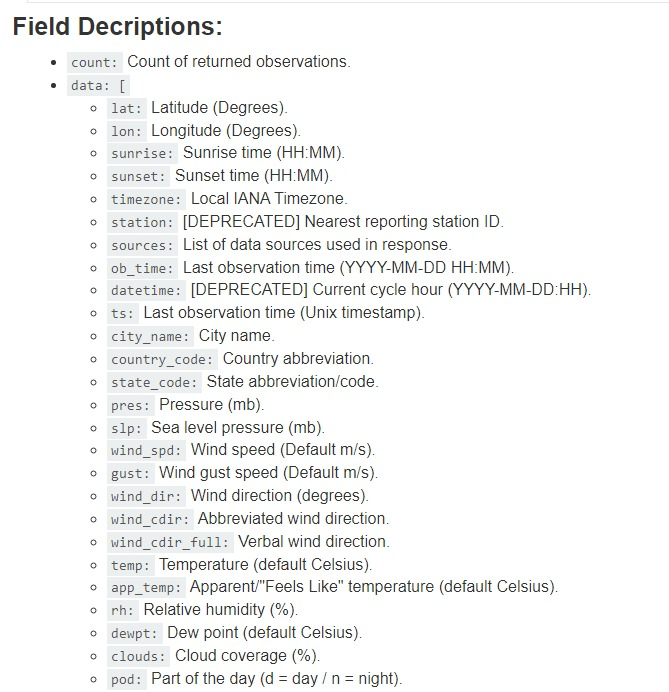

##### Transform process

In the context of `ETL` (Extract, Transform, Load), `transform` refers to the second step of the data integration process, where the extracted raw data is cleaned, enriched, and structured in preparation for loading into a central repository or target system.

In [ ]:
# to read more about this method
help(pd.DataFrame.from_dict)

In [12]:
# define a transform function -transfrom json returned result to a pandas clean dataframe
def transfrom(result):
    # comprehensive list of wanted fields only
    result_ = [item['data'][0] for item in result]
    
    # convert result_ list into a more readable format (pandas dataframe) 
    return pd.DataFrame.from_dict(result_)

In [13]:
data = transfrom(result)

In [14]:
# preview 
data

,app_temp,aqi,city_name,clouds,country_code,datetime,dewpt,dhi,dni,elev_angle,...,temp,timezone,ts,uv,vis,weather,wind_cdir,wind_cdir_full,wind_dir,wind_spd
0,23.9,20,Marrakesh,45,MA,2023-05-04:19,13.8,0,0,-9.78,...,24.0,Africa/Casablanca,1683229593,0,16,"{'description': 'Scattered clouds', 'code': 802, 'icon': 'c02n'}",N,north,360,7.20
1,21.5,19,Fès,88,MA,2023-05-04:19,9.8,0,0,-11.01,...,22.0,Africa/Casablanca,1683229594,0,16,"{'description': 'Broken clouds', 'code': 803, 'icon': 'c03n'}",NW,northwest,320,5.10
2,20.2,18,Casablanca,79,MA,2023-05-04:19,16.2,0,0,-9.20,...,20.1,Africa/Casablanca,1683230495,0,16,"{'description': 'Broken clouds', 'code': 803, 'icon': 'c03n'}",NE,northeast,42,3.09


### More transformations!

The `weather` column contains a json object that is unreadable, let's correct this mistake

In [91]:
# this function converts all fields containing dictionnary as values
def to_cleanValue(df=data):
    # get dataframe columns
    cols = df.columns
    # filter to get only unwanted columns names (containing dictionnaries as valus)
    cols_dict = [column for column in cols if type(df[column][0])==dict]
    # loop through these columns and solve the problem
    for column in cols_dict:
        keys = list()
        
         # get keys from dictionnary (loop through first record only and keep its order as standard order)
        for key in df[column][0]:
            keys.append(key)
            
        # define new dataframe holding results with -prefixed column names-
        df_ = pd.DataFrame(columns=keys).add_prefix(column+'-')
        
        ## append all items into one list
        store_items = list()
        for item in df[column]:
            store_items.append(item)
        
        # loop through keys to store final clean data into our intermediate df_
        for key in keys:
            ## order the columns to have same keys order -as json in semi-structured-
            df_[column+'-'+key] = [item[key] for item in store_items]
            
        # concatenate df_ with original dataframe-df-
        df = pd.concat([df,df_], axis=1)
        
        # delete old column after transformation
        df.drop(column, axis=1, inplace=True)
    return df

In [95]:
# apply changes to old dataframe
data= to_cleanValue()

In [97]:
# verify
data.head()

,app_temp,aqi,city_name,clouds,country_code,datetime,dewpt,dhi,dni,elev_angle,...,ts,uv,vis,wind_cdir,wind_cdir_full,wind_dir,wind_spd,weather-description,weather-code,weather-icon
0,23.9,20,Marrakesh,45,MA,2023-05-04:19,13.8,0,0,-9.78,...,1683229593,0,16,N,north,360,7.20,Scattered clouds,802,c02n
1,21.5,19,Fès,88,MA,2023-05-04:19,9.8,0,0,-11.01,...,1683229594,0,16,NW,northwest,320,5.10,Broken clouds,803,c03n
2,20.2,18,Casablanca,79,MA,2023-05-04:19,16.2,0,0,-9.20,...,1683230495,0,16,NE,northeast,42,3.09,Broken clouds,803,c03n


##### Load process

In the context of `ETL` (Extract, Transform, Load), `load` refers to the third and final step of the data integration process, where the transformed data is transferred and stored into a target system, such as a data warehouse, database, or other data storage platform

In [103]:
## for this purpose we'll make it simple and load the final data into a clean csv file
data.to_csv('clean_data.csv',index=False)

---
2023
&copy; [***Ismail Ouahbi***](https://ismailouahbi.github.io/), Machine Learning Engineer. All rights reserved.
